<a href="https://colab.research.google.com/github/claudiohfg/notebooks/blob/main/california_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
from tqdm import tqdm
import matplotlib.cm as colormap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

Adjust plotting style.

In [ ]:
plt.style.use('seaborn-notebook')
%matplotlib inline
sns.set()
sns.set_style('whitegrid')

# Utility functions

In [ ]:
def abs_scaler(ds: pd.DataFrame) -> pd.DataFrame:
    """
    Receive a dataframe, apply MaxAbsScaler transformation
    and return the dataset with the same columns and data
    in the same scale for analysis purposes.

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    
    Returns
    -------
    ds : pd.DataFrame
        Scaled dataset.
    """
    
    arr = MaxAbsScaler().fit_transform(ds.values)
    return pd.DataFrame(arr, columns=ds.columns)

In [ ]:
def label_feature(
    ds: pd.DataFrame,
    feature: str,
    n_parts: int,
    qcut=True) -> pd.DataFrame:
    """
    Generates label feature either distributing
    data equally or normally.

    Parameters
    ----------
    ds : pd.DataFrame
        Dataset to be scaled.
    
    Returns
    -------
    ds : pd.DataFrame
        Scaled dataset.
    """
    
    feat_sparse = f"{feature}_label"
    feat_label = f"{feature}_lbl"

    if qcut:
        ds[feat_sparse] = pd.qcut(ds[feature], n_parts)
    else:
        ds[feat_sparse] = pd.cut(ds[feature], n_parts)

    ds[feat_label] = LabelEncoder().fit_transform(ds[feat_sparse])
    ds.drop(labels=[feat_sparse], axis=1, inplace=True)

    return ds

# Load data

Use Sklearn loader for the California housing dataset from StatLib.

In [ ]:
california_housing = fetch_california_housing()

Print the description of the problem as-is from the source.

In [ ]:
print(california_housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

Attribute data and target to X and y to make it clearer for the reader which variables will hold which information.

In [ ]:
X = california_housing.data
y = california_housing.target

# Analyse data

Attribute the name 'Value' for the target information.

In [ ]:
df = pd.DataFrame(X, columns=california_housing.feature_names)
df['Value'] = y

Look for null values. There are none.

In [ ]:
df.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Value         0
dtype: int64

Sneak peak the dataset. The features are in different scales.

In [ ]:
df.sample(n=10).sort_index()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
3888,5.0623,35.0,5.972350,1.129032,1427.0,3.288018,34.21,-118.55,2.464
3973,2.8500,15.0,2.839518,1.000928,2173.0,2.015770,34.19,-118.58,1.875
4505,2.0200,42.0,2.931153,1.008606,2490.0,4.285714,34.05,-118.20,1.472
6765,4.8250,45.0,5.426829,0.881098,755.0,2.301829,34.11,-118.13,3.511
7223,1.8715,34.0,2.942116,1.019960,1962.0,3.916168,34.02,-118.16,1.396
7494,2.2411,44.0,5.928571,1.153846,601.0,3.302198,33.92,-118.24,1.064
9954,2.2536,16.0,5.432000,1.092000,898.0,1.796000,38.40,-122.36,2.012
10264,5.5918,20.0,6.193846,0.996923,1997.0,3.072308,33.90,-117.85,2.605
10453,5.1024,28.0,5.210744,0.962810,609.0,2.516529,33.46,-117.66,3.127
16561,4.1500,20.0,5.708861,1.006329,1236.0,2.607595,37.74,-121.40,3.224


In [ ]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Look for outliers within the features. There are plenty of them.

The features are transformed to a scale between -1 and 1 to let us plot them in the same graph without distortions.

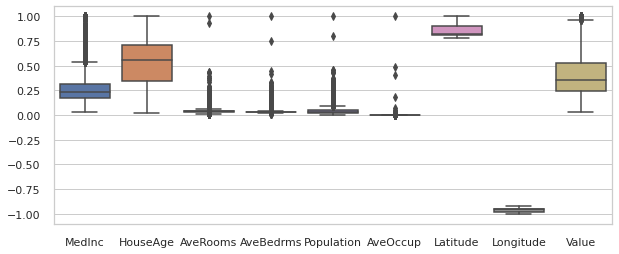

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.boxplot(
    data=abs_scaler(df)
)
plt.show()

Check histogram of features to plan how to interpret them. Some features are concentrated around the mean. 

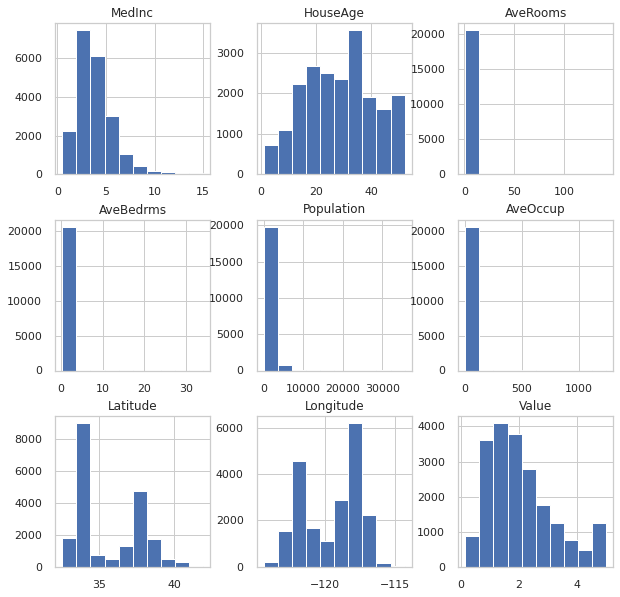

In [ ]:
df.hist(figsize=(10, 10))
plt.show()

Analyze which features should be quantized based on their spread.

The analysis will choose some features to be quantized and how (how many parts and if equally or normally).

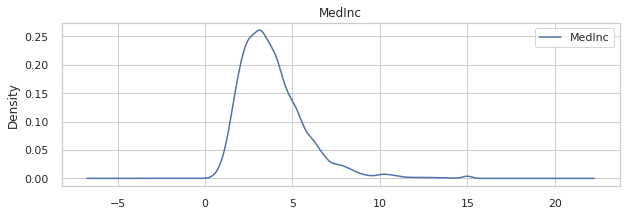

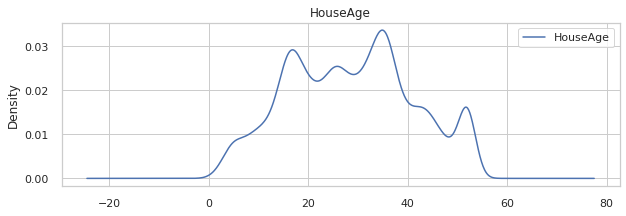

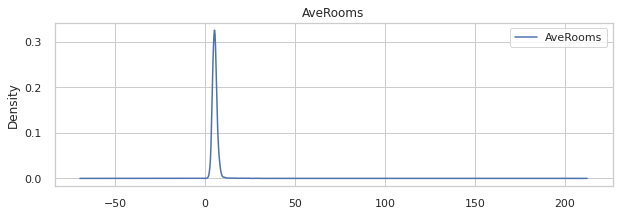

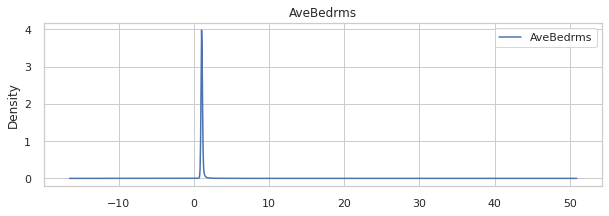

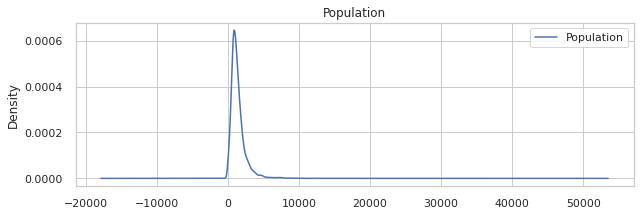

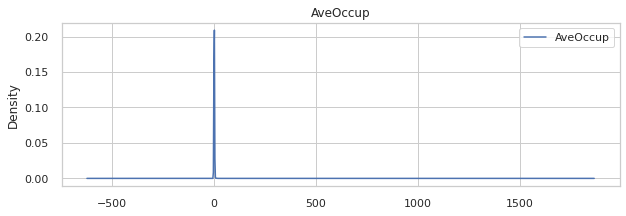

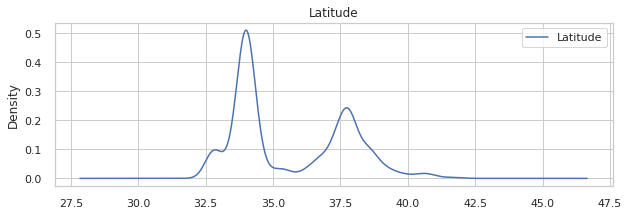

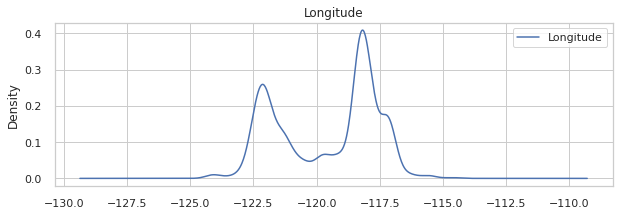

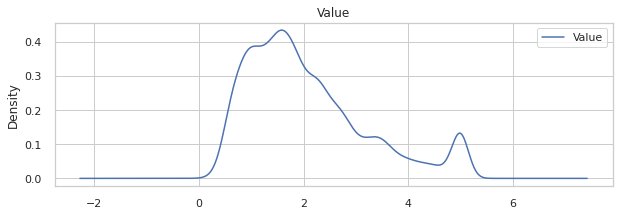

In [ ]:
features_to_quantize = []

for feature in df.columns:
    _mean = np.round(df[feature].mean(), 2)
    _stddev = np.round(df[feature].std(), 2)

    _max = np.round(df[feature].max(), 2)
    _min = np.round(df[feature].min(), 2)

    _ofs_max = (_max - _mean)/_stddev
    _ofs_min = (_mean - _min)/_stddev

    if _ofs_max > 3 or _ofs_min > 3:
        quants = 5 if np.log10(_stddev) < 2 else 10
        equally = False if _ofs_max < 10 and _ofs_min < 10 else True
        
        features_to_quantize.append([feature, quants, equally])

    df[[feature]].plot(figsize=(10, 3), title=feature, kind='kde')
    plt.show()

The result of this analysis is as follows.

In [ ]:
pd.DataFrame(features_to_quantize, columns=['Feature', 'Quantas', 'Equally'])

,Feature,Quantas,Equally
0,MedInc,5,False
1,AveRooms,5,True
2,AveBedrms,5,True
3,Population,10,True
4,AveOccup,5,True


The quantization will create label features for each feature, dividing them as defined in the previous step.

In [ ]:
for [feature, quants, equally] in features_to_quantize:
    df = label_feature(df, feature, quants, equally)

Check features correlation using a heatmap.

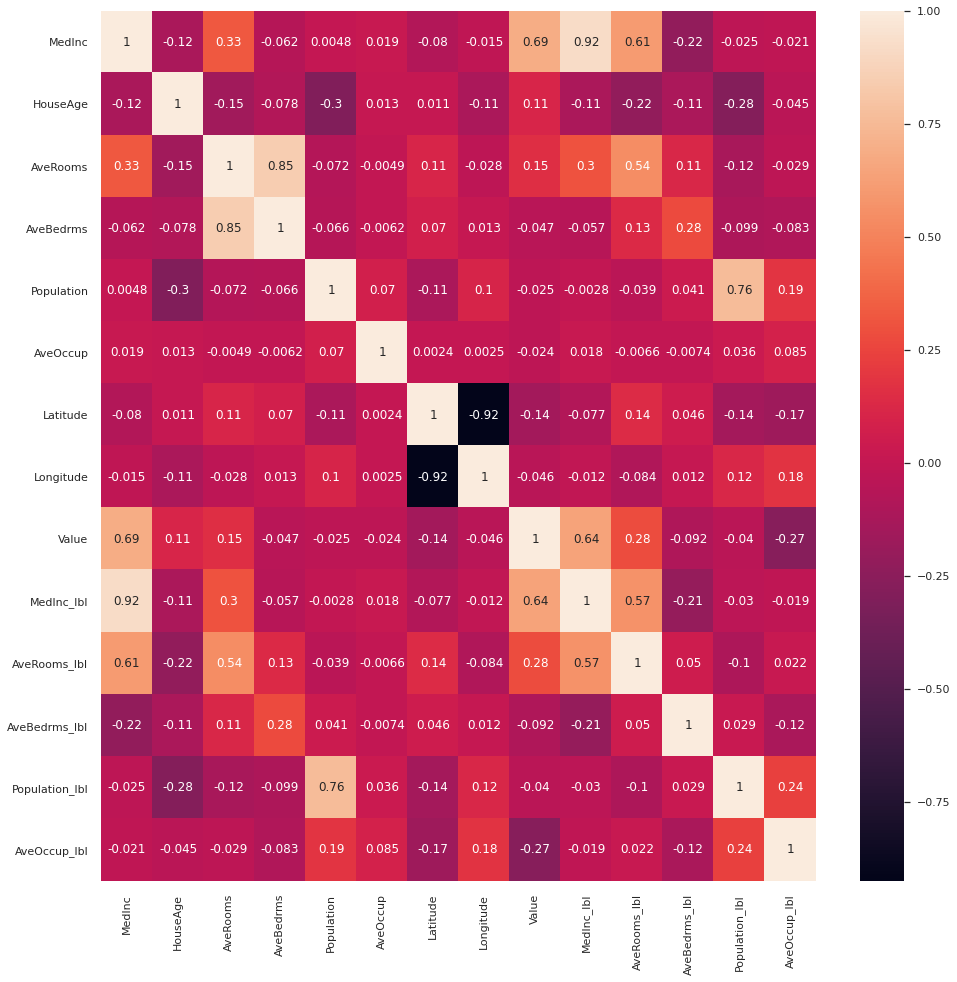

In [ ]:
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(16, 16))
g = sns.heatmap(
    df_corr, annot=True
)
plt.show()

Remove features created in the quatization step which are highly correlated to the original features.

In [ ]:
for [feat, feat_lbl] in [
    [col.split('_')[0], col]
    for col in df.columns
    if '_lbl' in col
]:
    if df_corr.loc[feat, feat_lbl] >= 0.9:
        df.drop(columns=[feat_lbl], inplace=True)
        print(f'Dropping {feat_lbl}')

df_corr = df.corr()

Dropping MedInc_lbl


Sort the features descending by the correlation to the Value.

In [ ]:
arr = list(df_corr.loc['Value'].items())
arr.sort(key=lambda x: np.abs(x[1]), reverse=True)
arr

[('Value', 1.0),
 ('MedInc', 0.6880752079585366),
 ('AveRooms_lbl', 0.28381754686610305),
 ('AveOccup_lbl', -0.26712369679221737),
 ('AveRooms', 0.15194828974145688),
 ('Latitude', -0.14416027687465754),
 ('HouseAge', 0.10562341249321003),
 ('AveBedrms_lbl', -0.09153861212725975),
 ('AveBedrms', -0.046700512969486546),
 ('Longitude', -0.04596661511797851),
 ('Population_lbl', -0.03992325526395317),
 ('Population', -0.02464967888889457),
 ('AveOccup', -0.02373741295613417)]

Remove features with less than 5% correlation to the Value.

In [ ]:
columns = [x[0] for x in arr if np.abs(np.round(x[1], 2)) >= 0.05]

df = df[columns].copy()

This is the resulting dataset.

In [ ]:
df.head()

,Value,MedInc,AveRooms_lbl,AveOccup_lbl,AveRooms,Latitude,HouseAge,AveBedrms_lbl,AveBedrms,Longitude
0,4.526,8.3252,4,1,6.984127,37.88,41.0,1,1.023810,-122.23
1,3.585,8.3014,3,0,6.238137,37.86,21.0,0,0.971880,-122.22
2,3.521,7.2574,4,2,8.288136,37.85,52.0,3,1.073446,-122.24
3,3.413,5.6431,3,1,5.817352,37.85,52.0,3,1.073059,-122.25
4,3.422,3.8462,4,0,6.281853,37.85,52.0,3,1.081081,-122.25


Create a label feature for the Value to help us plot some graphs.

In [ ]:
columns = [
    col for col in df.columns
    if 'tude' not in col and '_lbl' not in col
]

df = label_feature(df, 'Value', 5, False)
columns = columns + ['Value_lbl']

Scatter plot matrix of the non label features.

Did we miss any hidden feature or relationship?

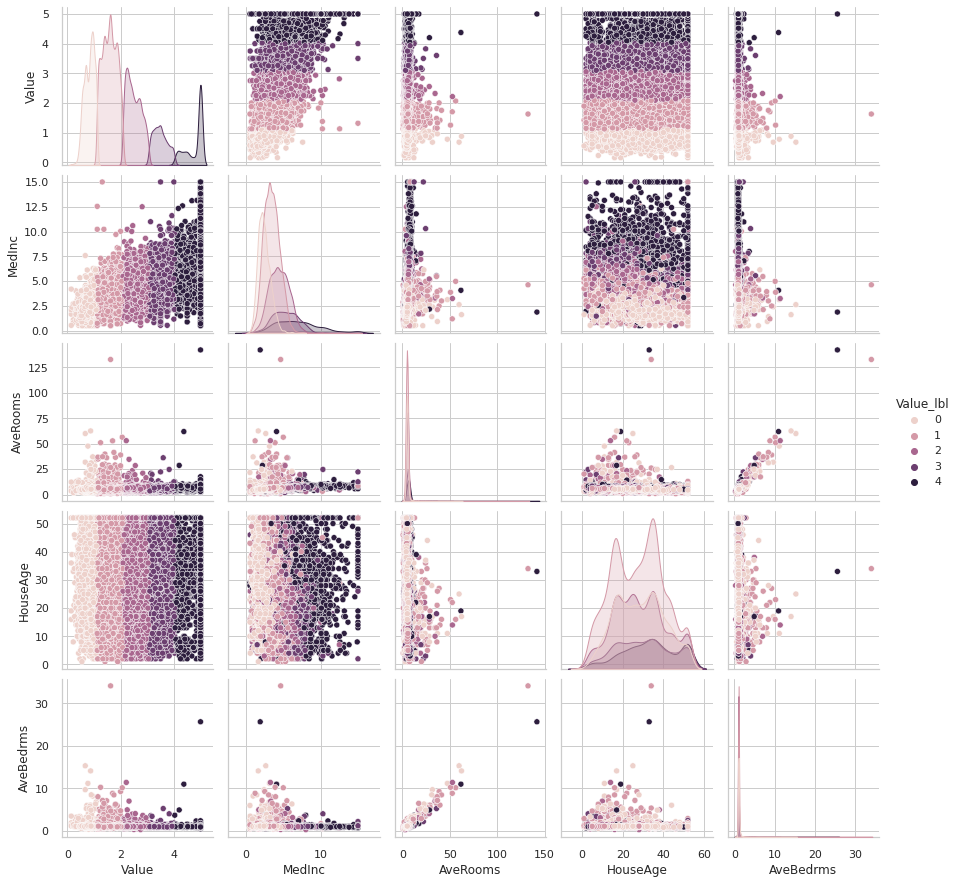

In [ ]:
sns.pairplot(df[columns], hue='Value_lbl')

plt.show()

Plot the values by Latitude and Longitude to look for a relationship. 

Clearly houses closer to the sea tend to have higher values. Perhaps we should explore this.

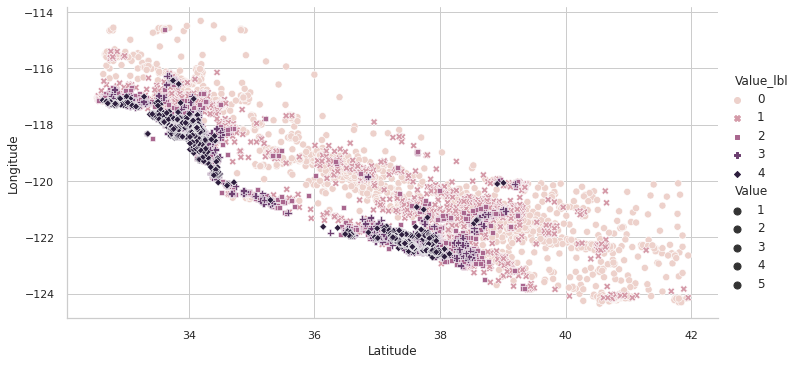

In [ ]:
df.sort_values(by=['Value'], inplace=True)

sns.relplot(
    x="Latitude",
    y="Longitude",
    size="Value",
    sizes=(50, 50),
    hue="Value_lbl",
    style="Value_lbl",
    data=df,
    aspect=2
)
plt.show()

# Split data

Data is split into 2 sets:
1.   Train: we will analyse this set and used it to train the model.
2.   Eval: this is like production, it will show us if the model is capable of predicting real like situations.

Remember to drop the label feature created for Value, since Value is the target feature.


In [ ]:
eval = df.sample(frac=0.2).index

df_train = df.drop(columns=['Value_lbl'], index=eval)
df_eval = df.drop(columns=['Value_lbl']).iloc[eval]

X_train, y_train = df_train.drop(
    labels='Value', axis=1
).values, df_train['Value'].values

X_eval, y_eval = df_eval.drop(
    labels='Value', axis=1
).values, df_eval['Value'].values

# Scale

Data is "StandardScaled" so outliers are highlighted and then "MaxAbsScaled" so every feature is constrained within the same boundaries, preventing the algorithm to consider one feature above the others only because of the original scale.

Use a Pipeline to apply both transformations at the same time.

In [ ]:
scaler = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('MaxAbsScaler', MaxAbsScaler())
])

scaler.fit(X_train, y_train)

X_train_scaled = scaler.transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

# Clustering feature

Use a clustering algorithm to categorize data, creating a new feature.

Start by calculating the proper amount of clusters with a Silhouette score.


In [ ]:
result = []

for n_clusters in tqdm(range(
    X_train_scaled.shape[1]//2,
    X_train_scaled.shape[1])):
    kmeans = KMeans(n_clusters=n_clusters).fit(X_train_scaled, y_train)
    score = silhouette_score(
        X_train_scaled,
        kmeans.fit_predict(X_train_scaled, y_train))
    result.append([n_clusters, score])

100%|██████████| 5/5 [00:30<00:00,  6.13s/it]


The best result is the one with the highest Silhouette score.

In [ ]:
result.sort(key=lambda x: x[1], reverse=True)
result

[[4, 0.22547902188703636],
 [5, 0.2118428944018804],
 [6, 0.20510846614101633],
 [8, 0.20038090129520222],
 [7, 0.1974212965388949]]

Train a clustering algorithm passing the amount of clusters determined in the previous step.

In [ ]:
kmeans = KMeans(n_clusters=result[0][0]).fit(X_train_scaled, y_train)

Predict the cluster for the training data.

In [ ]:
k_pred = kmeans.predict(X_train_scaled, y_train)
k_pred = k_pred / (result[0][0] - 1)

Check how the clusters are distributed in the map to check if there is any relationship to the geography of the area. It is unlikely.

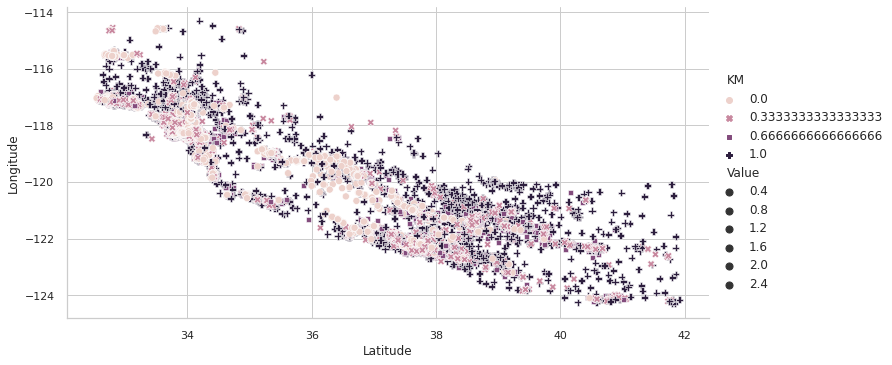

In [ ]:
df_train['KM'] = k_pred
df_train.sort_values(by=['Value'], ascending=False, inplace=True)

sns.relplot(
    x="Latitude",
    y="Longitude",
    size="Value",
    sizes=(50, 50),
    hue="KM",
    style="KM",
    data=df_train,
    aspect=2
)
plt.show()

Concatenate the cluster feature to the training data.

In [ ]:
X_train_scaled = np.concatenate(
    (
        X_train_scaled,
        np.reshape(k_pred, (k_pred.shape[0], 1))
    ), axis=1)

Predict the cluster for the evaluation data.

In [ ]:
k_pred = kmeans.predict(X_eval_scaled, y_eval)
k_pred = k_pred / (result[0][0] - 1)

Concatenate the cluster feature to the evaluation data.

In [ ]:
X_eval_scaled = np.concatenate(
    (
        X_eval_scaled,
        np.reshape(k_pred, (k_pred.shape[0], 1))
    ), axis=1)

# Train model

Before choosing the best algorithm to predict the Value feature, create a scorer using make_scorer and mean_squared_error functions from Sklearn.

In [ ]:
mse = make_scorer(mean_squared_error, greater_is_better=False, needs_proba=False)

Then create a cross validation iterator. This iterator will split data in 5 different ways and repeat the process twice. It must be enough to let us choose the best algorithm.

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=0)

The chosen models are LGBMRegressor, XGBRegressor and SGDRegressor.

In [ ]:
models = [
    ('LGBMRegressor', LGBMRegressor),
    ('XGBRegressor', XGBRegressor),
    ('SGDRegressor', SGDRegressor)
]

In [ ]:
params = [
    {
        'boosting_type': ['gbdt', 'dart', 'goss'],
        'num_leaves': [17, 31, 63],
        'learning_rate': [0.1, 1e-2, 1e-3],
        'n_estimators': [100, 150, 200, 250, 300],
    },
    {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 1e-2, 1e-3],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'n_jobs': [os.cpu_count()],
        'objective': ['reg:squarederror']
    },
    {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'tol': [1e-3, 1e-4, 1e-5],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'early_stopping': [True, False],
        'n_iter_no_change': [5, 10, 15],
    }
]

In [ ]:
best_params = []
scores = []

for idx in tqdm(range(len(models))):
    name, model = models[idx]
    rscv = RandomizedSearchCV(
        model(), params[idx],
        scoring=mse,
        cv=RepeatedKFold(n_splits=3, n_repeats=1, random_state=0))
    rscv.fit(X_train_scaled, y_train)
    best_params.append(rscv.best_params_)
    scores.append(f'Model {name} \t Score {rscv.best_score_}')

print()

for score in scores:
    print(score)

100%|██████████| 3/3 [02:26<00:00, 48.96s/it]

Model LGBMRegressor 	 Score -0.0536186584200985
Model XGBRegressor 	 Score -0.05180778052680588
Model SGDRegressor 	 Score -0.1033626542415934


In [ ]:
best_models = [(name, model(**params)) for (name, model), params in list(zip(models, best_params))]

By means of a cross_val_score function, process the results of the predictions for each algorithm.

In [ ]:
result = []
scores = dict()

for name, model in tqdm(best_models):
    score = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring=mse,
        n_jobs=-1)
    scores[name] = score.tolist()
    result.append(np.abs(np.mean(score)))

100%|██████████| 3/3 [05:01<00:00, 100.58s/it]


And this is the result.

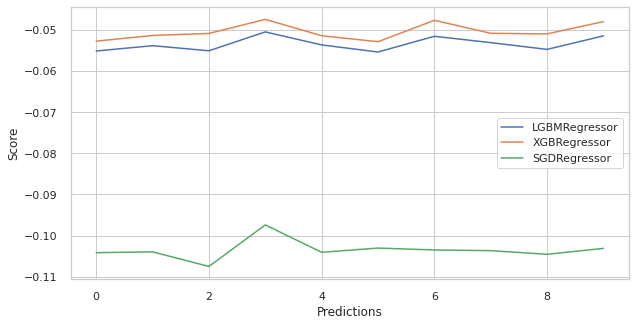

In [ ]:
pd.DataFrame(scores).plot(
    kind='line',
    figsize=(10,5),
    xlabel='Predictions',
    ylabel='Score',
    sort_columns=True
)
plt.show()

The best algorithm for this problem is chosen as shown below.

In [ ]:
selection = list(zip(result, best_models))
selection.sort(key=lambda x: x[0])
selected_model = selection[0][1][1]
type(selected_model)

xgboost.sklearn.XGBRegressor

# Predict

Train the chosen algorithm with all the training data.

In [ ]:
selected_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=2, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

And make the predictions for the evaluation data.

In [ ]:
y_pred = selected_model.predict(X_eval_scaled)
print(f'MSE = {mean_squared_error(y_eval, y_pred)}')

MSE = 0.025301058811519023


Plot a graph to analyse if we can improve the results.

Create label feature for Error to allow a plot that shows where the algorithm did not predict correctly.

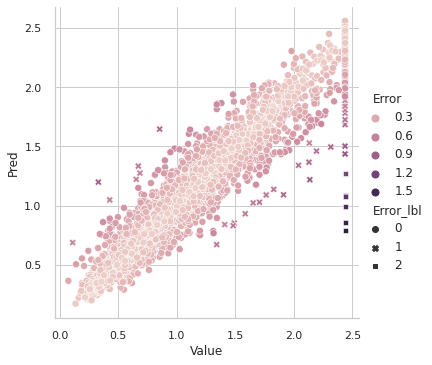

In [ ]:
df_eval['Pred'] = y_pred
df_eval['Error'] = np.abs(df_eval.Value - df_eval.Pred)
df_eval = label_feature(df_eval, 'Error', 3, False)

sns.relplot(
    x='Value',
    y='Pred',
    hue='Error',
    style='Error_lbl',
    size='Error',
    sizes=(50,50),
    data=df_eval
)
plt.show()

There are some outliers within the results. Either we can improve the prediction by means of creating new features or c'est la vie.

Analyse eval data for more information, but instead of Value, use Error as calculated above.

Sort values and drop index to allow a line plot of the Error feature.

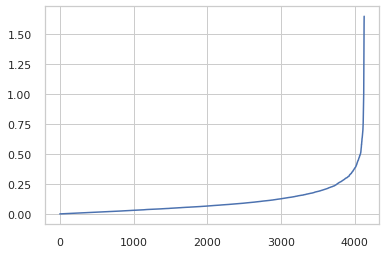

In [ ]:
df_eval.sort_values(by=['Error'], inplace=True)
df_eval.reset_index(drop=True, inplace=True)

df_eval.Error.plot()
plt.show()

Analyse error distribution on Latitude and Longitude to check if we have should created a feature based on geographical information.

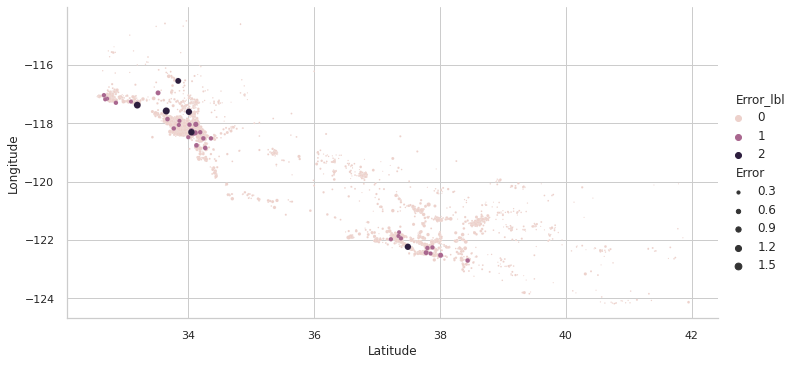

In [ ]:
sns.relplot(
    x="Latitude",
    y="Longitude",
    size="Error",
    sizes=(1, 50),
    hue="Error_lbl",
    data=df_eval,
    aspect=2
)
plt.show()

Go back to square one. ;-)